## The performance is very satisfactory since the algorithm converging to a good approximation of the true posterior

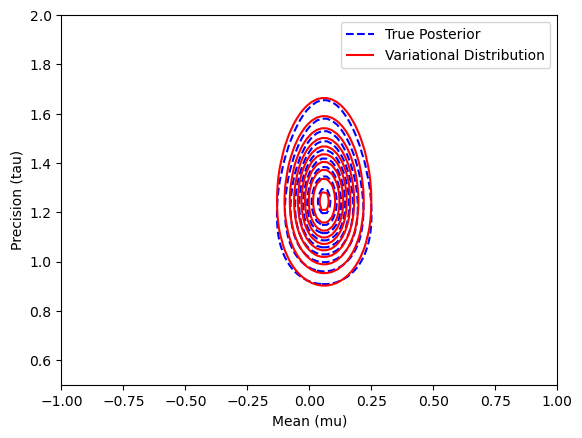

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

np.random.seed(1)

# Define true parameters
mu_true = 0
tau_true = 1
# Generate synthetic data with 100 points
y = np.random.normal(mu_true, 1/np.sqrt(tau_true), 100)
# Set hyperparameters
a_0 = 1
b_0 = 1
mu_0 = 0
lambda_0 = 2

# Coordinate ascent variational inference for Univariate Gaussian
def cavi_univariate_gaussian(y, a_0, b_0, mu_0, lambda_0, tol=1e-6, max_iter=1000):
    n = len(y)  
    # Update a_K based on the data
    a_K = a_0 + n / 2   
    # Calculate mu_K using the data and hyperparameters
    mu_K = (lambda_0 * mu_0 + n * np.mean(y)) / (lambda_0 + n)    
    # Initialize b_K
    b_K = b_0
    lambda_K = 0   
    # Iterate until convergence
    for i in range(max_iter):
        b_K_prev = b_K
        lambda_K_prev = lambda_K      
        # Update lambda_K using the current value of b_K
        lambda_K = (lambda_0 + n) * a_K / b_K      
        # Update b_K using the current value of lambda_K
        b_K = b_0 + 0.5 * np.sum((y - mu_K)**2) + 0.5 * lambda_0 * n * (mu_K - mu_0)**2 / (lambda_0 + n)      
        # Check for convergence
        if np.abs(b_K - b_K_prev) < tol and np.abs(lambda_K - lambda_K_prev) < tol:
            break

    return mu_K, a_K, b_K, lambda_K

# Run the CAVI algorithm
mu_K, a_K, b_K, lambda_K = cavi_univariate_gaussian(y, a_0, b_0, mu_0, lambda_0)
mu_range = np.linspace(mu_true - 1, mu_true + 1, 100)
tau_range = np.linspace(tau_true - 0.5, tau_true + 1, 100)
# Create a grid for mu and tau values
mu_grid, tau_grid = np.meshgrid(mu_range, tau_range)

posterior_true = np.empty_like(mu_grid)
posterior_variational = np.empty_like(mu_grid)

# Calculate the true posterior and variational posterior for each mu and tau combination
for i in range(100):
    for j in range(100):
        mu = mu_grid[i, j]
        tau = tau_grid[i, j]
        if tau == 0:
            continue
        # Calculate the log-likelihood for the current mu and tau
        log_likelihood = np.sum(norm.logpdf(y, mu, 1/np.sqrt(tau)))       
        # Calculate the prior for the current mu and tau
        prior = norm.pdf(mu, mu_0, 1/np.sqrt(lambda_0)) * gamma.pdf(tau, a_0, scale=1/b_0)
        posterior_true[i, j] = np.exp(log_likelihood) * prior       
        # Calculate the variational posterior using the CAVI results
        posterior_variational[i, j] = norm.pdf(mu, mu_K, 1/np.sqrt(lambda_K)) * gamma.pdf(tau, a_K, scale=1/b_K)

# Plot the true and variational posterior distributions as contour plots
true_posterior_contour = plt.contour(mu_grid, tau_grid, posterior_true, colors='blue', linestyles='dashed', levels=10)
variational_contour = plt.contour(mu_grid, tau_grid, posterior_variational, colors='red', levels=10)
plt.xlabel('Mean (mu)')
plt.ylabel('Precision (tau)')
# Add a legend to the plot
h1,_ = true_posterior_contour.legend_elements()
h2,_ = variational_contour.legend_elements()
plt.legend([h1[0], h2[0], 'Data Points'], ['True Posterior', 'Variational Distribution'])
plt.show()       
